In [1]:
import tensorflow as tf
import math
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


2025-11-04 16:04:35.782359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762272275.979876      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762272276.040045      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."


Num GPUs Available: 1


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

EXPERIMENT_NAME = "densenet_simam"  # Options: "densenet_eca", "densenet_ca", "densenet_both"
ATTENTION_TYPE = "simam"  # Options: cbam, simam, gam, triplet, shuffle, bam


In [4]:
datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes


Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [5]:
# ============================================================================
# SimAM (Simple Parameter-Free Attention Module) - ICML 2021
# Lightweight & Parameter-Free: Uses energy function
# Paper: "SimAM: A Simple, Parameter-Free Attention Module"
# ============================================================================
class SimAM(layers.Layer):
    """
    SimAM: Parameter-free attention using energy function
    Zero parameters added! Very efficient

    Args:
        e_lambda: lambda parameter for energy function (default: 1e-4)
    """
    def __init__(self, e_lambda=1e-4, **kwargs):
        super(SimAM, self).__init__(**kwargs)
        self.e_lambda = e_lambda

    def call(self, inputs):
        b, h, w, c = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        n = h * w - 1

        # Calculate mean and variance
        x_mean = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        x_var = tf.reduce_sum(
            tf.square(inputs - x_mean),
            axis=[1, 2],
            keepdims=True
        ) / tf.cast(n, tf.float32)

        # Energy function
        x_minus_mu_square = tf.square(inputs - x_mean)
        y = x_minus_mu_square / (4 * (x_var + self.e_lambda)) + 0.5

        # Attention weights
        attention = tf.nn.sigmoid(y)

        return inputs * attention

    def get_config(self):
        config = super(SimAM, self).get_config()
        config.update({"e_lambda": self.e_lambda})
        return config



def build_densenet_with_attention(
    num_classes,
    img_size=(224, 224),
    attention_name='cbam',
    dropout_rate=0.3
):
    """
    Build DenseNet121 with modern attention mechanisms

    Architecture: Input -> DenseNet121 -> ATTENTION -> Dense Layers

    Args:
        num_classes: number of output classes
        img_size: input image size
        attention_name: which attention to use
        dropout_rate: dropout rate for dense layers

    Returns:
        Keras Model
    """
    from tensorflow.keras.applications import DenseNet121
    from tensorflow.keras import Model

    # Load DenseNet121 backbone
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=img_size + (3,)
    )

    x = base_model.output

    # Add Attention Module
    attention_map = {
        # 'cbam': CBAM,
        'simam': SimAM,
        # 'gam': GAM,
        # 'triplet': TripletAttention,
        # 'shuffle': ShuffleAttention,
        # 'bam': BAM
    }

    if attention_name.lower() in attention_map:
        AttentionLayer = attention_map[attention_name.lower()]
        x = AttentionLayer(name=f'{attention_name}_attention')(x)
        print(f"✓ Added {attention_name.upper()} attention after DenseNet121")
    else:
        print(f"⚠ Unknown attention: {attention_name}. Proceeding without attention.")

    # Classification Head (matching your original architecture)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)

    x = layers.Dense(1024, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)

    x = layers.Dense(512, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(dropout_rate, name='dropout_3')(x)

    x = layers.Dense(256, activation='relu', name='fc3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Dropout(dropout_rate, name='dropout_4')(x)

    x = layers.Dense(128, activation='relu', name='fc4')(x)

    output = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(
        inputs=base_model.input,
        outputs=output,
        name=f'DenseNet121_{attention_name}'
    )

    return model




In [6]:
print(f"\n{'='*70}")
print(f"Building DenseNet121 with {ATTENTION_TYPE.upper()} attention")
print(f"{'='*70}\n")

model = build_densenet_with_attention(
    num_classes=num_classes,
    img_size=IMG_SIZE,
    attention_name=ATTENTION_TYPE,
    dropout_rate=DROPOUT_RATE
)

# Make entire model trainable (same as your setup)
model.trainable = True

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR,
    weight_decay=0.01
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



Building DenseNet121 with SIMAM attention



I0000 00:00:1762272295.221865      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Added SIMAM attention after DenseNet121


In [7]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Parameter increase vs baseline: +{model.count_params() - 8788843:,}")



Model Summary:
Total parameters: 8,788,843
Trainable parameters: 8,701,611
Parameter increase vs baseline: +0


In [8]:
checkpoint_cb = ModelCheckpoint(
    "best_densenet_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print(f"\n{'='*70}")
print("Starting training...")
print(f"{'='*70}\n")

history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

# Save history
with open(f'{EXPERIMENT_NAME}_history.json', 'w') as f:
    json.dump(history.history, f)



Starting training...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1762272404.226000     119 service.cc:148] XLA service 0x7fc13c0026b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762272404.226895     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762272413.680179     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762272498.837015     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.1529 - loss: 3.1037
Epoch 1: val_accuracy improved from -inf to 0.38795, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 488s 665ms/step - accuracy: 0.1532 - loss: 3.1022 - val_accuracy: 0.3880 - val_loss: 1.8356 - learning_rate: 0.0010
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4740 - loss: 1.4789
Epoch 2: val_accuracy improved from 0.38795 to 0.46466, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 115s 258ms/step - accuracy: 0.4741 - loss: 1.4786 - val_accuracy: 0.4647 - val_loss: 1.6697 - learning_rate: 0.0010
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6265 - loss: 1.0373
Epoch 3: val_accuracy did not improve from 0.46466
445/445 ━━━━━━━━━━━━━━━━━━━━ 119s 268ms/step - accuracy: 0.6266 - loss: 1.0371 - val_accuracy: 0.4519 - val_loss: 1.8828 - learning_rate: 0.0010
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.699

In [9]:
print("\nEvaluating on test set...")

test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Metrics
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]
num_params = model.count_params()


print(f"\n{'='*70}")
print("FINAL RESULTS")
print(f"{'='*70}")
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Attention Type: {ATTENTION_TYPE.upper()}")
print(f"{'-'*70}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"Parameters:     {num_params:,}")
print(f"Param increase: +{num_params - 8788843:,}")
print(f"{'='*70}\n")

# Compare with baseline
baseline_acc = 0.9489
baseline_f1 = 0.9235
print("COMPARISON WITH BASELINE:")
print(f"Accuracy improvement: {(test_acc - baseline_acc)*100:+.2f}%")
print(f"F1 improvement:       {(f1 - baseline_f1)*100:+.2f}%")



Evaluating on test set...
374/374 ━━━━━━━━━━━━━━━━━━━━ 132s 323ms/step

FINAL RESULTS
Experiment: densenet_simam
Attention Type: SIMAM
----------------------------------------------------------------------
Test Loss:      0.2010
Test Accuracy:  0.9492
Precision:      0.9104
Recall:         0.9176
F1 Score:       0.9120
Parameters:     8,788,843
Param increase: +0

COMPARISON WITH BASELINE:
Accuracy improvement: +0.03%
F1 improvement:       -1.15%


In [10]:
results = {
    "Model": [EXPERIMENT_NAME],
    "Attention": [ATTENTION_TYPE],
    "Params": [num_params],
    "Param_increase": [num_params - 8788843],
    "Test_Loss": [f"{test_loss:.4f}"],
    "Test_Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"],
    "Acc_vs_baseline": [f"{(test_acc - baseline_acc)*100:+.2f}%"],
    "F1_vs_baseline": [f"{(f1 - baseline_f1)*100:+.2f}%"]
}

import pandas as pd
df = pd.DataFrame(results)
print("\n" + df.to_markdown(index=False))

# Save to CSV for easy comparison
df.to_csv(f'{EXPERIMENT_NAME}_results.csv', index=False)

# Save model
model.save(f'{EXPERIMENT_NAME}_final_model.keras')
model.save_weights(f'{EXPERIMENT_NAME}_final.weights.h5')



| Model          | Attention   |   Params |   Param_increase |   Test_Loss |   Test_Acc |   Precision |   Recall |    F1 | Acc_vs_baseline   | F1_vs_baseline   |
|:---------------|:------------|---------:|-----------------:|------------:|-----------:|------------:|---------:|------:|:------------------|:-----------------|
| densenet_simam | simam       |  8788843 |                0 |       0.201 |     0.9492 |      0.9104 |   0.9176 | 0.912 | +0.03%            | -1.15%           |


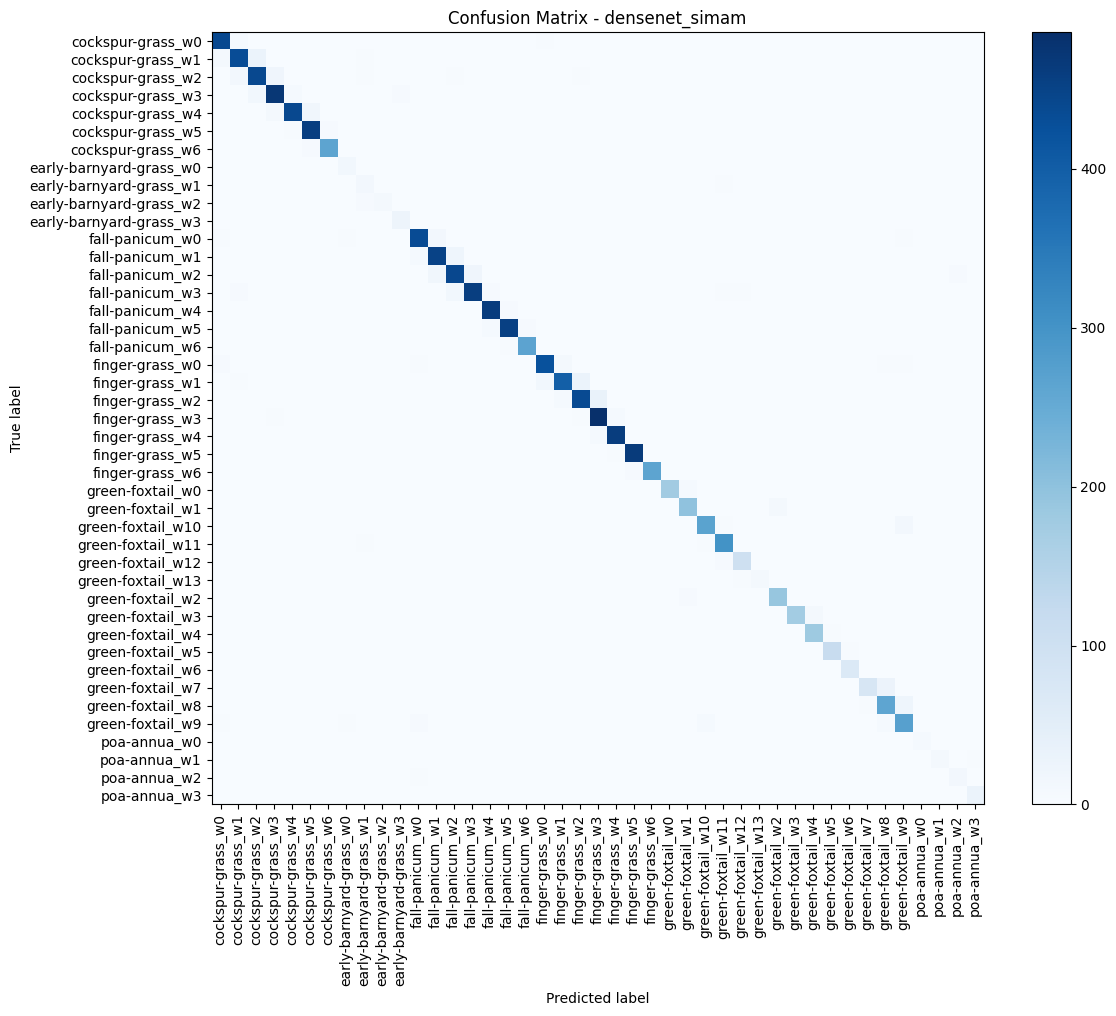

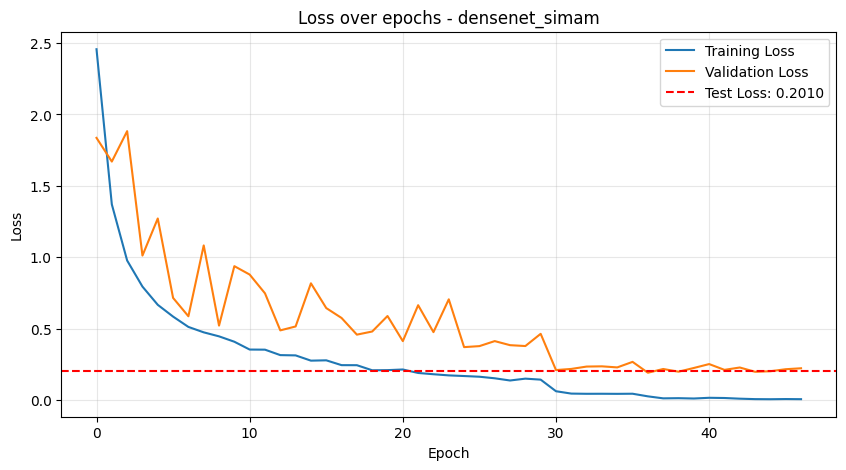

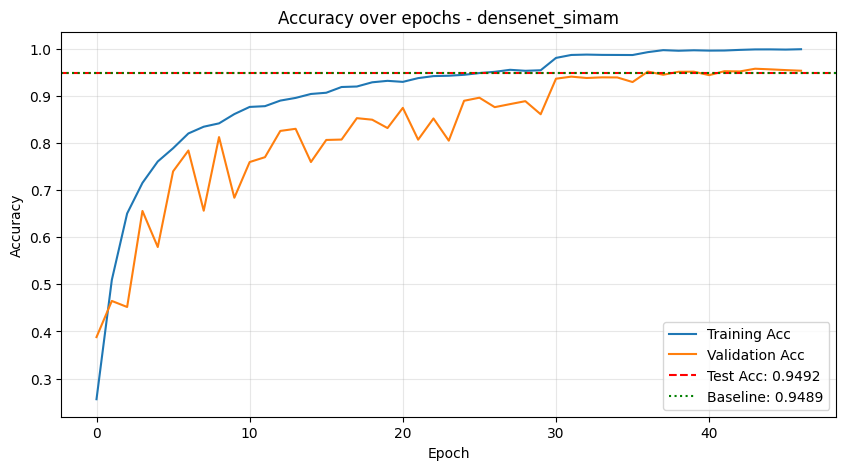


All results saved with prefix: densenet_simam_
Training complete! 🎉


In [11]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - {EXPERIMENT_NAME}")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(f'{EXPERIMENT_NAME}_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.legend()
plt.title(f"Loss over epochs - {EXPERIMENT_NAME}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.savefig(f'{EXPERIMENT_NAME}_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# Accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Acc: {test_acc:.4f}')
plt.axhline(y=baseline_acc, color='g', linestyle=':', label=f'Baseline: {baseline_acc:.4f}')
plt.legend()
plt.title(f"Accuracy over epochs - {EXPERIMENT_NAME}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.savefig(f'{EXPERIMENT_NAME}_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAll results saved with prefix: {EXPERIMENT_NAME}_")
print("Training complete! 🎉")
